In [1]:
# !pip install scikit-image

import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pathlib import Path

from tqdm import tqdm

import os
import glob
import json
import random

import skimage as ski

from sklearn.metrics import average_precision_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import losses, utils
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from typing import List, Tuple
from enum import IntEnum
import time


d:\User\yannick\envs\hacking_the_human\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
on_pc = os.path.isdir('data')
if on_pc: 
    data_directory = "data"
else:
    data_directory = "/kaggle/input/hubmap-hacking-the-human-vasculature"

# Goals of the Competition
Goal of the Competition
The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. You'll create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

Your help in automating the segmentation of microvasculature structures will improve researchers' understanding of how the blood vessels are arranged in human tissues

# Dataset description
Your goal in this competition is to locate microvasculature structures (blood vessels) within human kidney histology slides.

The competition data comprises tiles extracted from five Whole Slide Images (WSI) split into two datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.

- All of the test set tiles are from Dataset 1.
- Two of the WSIs make up the training set, two WSIs make up the public test set, and one WSI makes up the private test set.
- The training data includes Dataset 2 tiles from the public test WSI, but not from the private test WSI.

We also include, as Dataset 3, tiles extracted from an additional nine WSIs. These tiles have not been annotated. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data drawn from the public test set to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 650 tiles in the full test set.

You may find resources from the previous HuBMAP competitions useful as well:

- HuBMAP: Hacking the Kidney (https://www.kaggle.com/competitions/hubmap-kidney-segmentation/)
- HuBMAP + HPA: Hacking the Human Body (https://www.kaggle.com/competitions/hubmap-organ-segmentation/)

## Files and Field Descriptions
**{train|test}/ Folders** - containing TIFF images of the tiles. Each tile is 512x512 in size.

In [4]:
def number_tif_files(directory):
    file_pattern = f'{directory}*.tif'
    tif_files = glob.glob(file_pattern)
    print(f'Number .tif files in {directory}: {len(tif_files)}')

number_tif_files(f'{data_directory}/train/')
number_tif_files(f'{data_directory}/test/')

Number .tif files in data/train/: 7033
Number .tif files in data/test/: 1


**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page (https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview/evaluation) for more details:
- bitová maska stejné velikosti jako obrázek (512 x 512), která je převedena na **prediction_string**
- **prediction_string** has the format 0 {confidence} {EncodedMask}
- Segmentation is calculated using IoU (Intersection over Union) with a threshold of 0.6

In [5]:
pd.read_csv(f'{data_directory}/sample_submission.csv')

id  height  width                   prediction_string
0  72e40acccadf     512    512  0 1.0 eNoLTDAwyrM3yI/PMwcAE94DZA==

**polygons.jsonl** - Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:
- id Identifies the corresponding image in train/
- annotations A list of mask annotations with:
- type Identifies the type of structure annotated:
    - **blood_vessel** The target structure. Your goal in this competition is to predict these kinds of masks on the test set.
    - **glomerulus** A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should *ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives*. Annotations are provided for test set tiles in the hidden version of the dataset.
    - **unsure** A structure the expert annotators cannot confidently distinguish as a blood vessel.
- coordinates A list of polygon coordinates defining the segmentation mask.

In [6]:
jsonObj = pd.read_json(path_or_buf=f"{data_directory}/polygons.jsonl", lines=True, encoding="UTF-8")
jsonObj

id                                        annotations
0     0006ff2aa7cd  [{'type': 'glomerulus', 'coordinates': [[[167,...
1     00168d1b7522  [{'type': 'glomerulus', 'coordinates': [[[511,...
2     0033bbc76b6b  [{'type': 'blood_vessel', 'coordinates': [[[16...
3     003504460b3a  [{'type': 'blood_vessel', 'coordinates': [[[40...
4     004daf1cbe75  [{'type': 'blood_vessel', 'coordinates': [[[14...
...            ...                                                ...
1628  ff434af74304  [{'type': 'blood_vessel', 'coordinates': [[[29...
1629  ff4897b3eda6  [{'type': 'blood_vessel', 'coordinates': [[[29...
1630  ff66dec71c4c  [{'type': 'blood_vessel', 'coordinates': [[[11...
1631  ff99cdef0f2a  [{'type': 'blood_vessel', 'coordinates': [[[24...
1632  ffd3d193c71e  [{'type': 'glomerulus', 'coordinates': [[[450,...

[1633 rows x 2 columns]

In [7]:
#with open(f"{data_directory}/polygons.jsonl", "rb") as f:
#    print(json.load(f"{data_directory}/polygons.jsonl"))

with open(f"{data_directory}/polygons.jsonl",'r') as json_file:
    json_list = list(json_file)

result = {}
result_ids = []
for json_str in json_list:
    obj = json.loads(json_str)
    result[obj["id"]] = obj["annotations"]
    result_ids.append(obj["id"])

print(result["0006ff2aa7cd"])


[{'type': 'glomerulus', 'coordinates': [[[167, 249], [166, 249], [165, 249], [164, 249], [163, 249], [162, 249], [161, 249], [160, 249], [159, 249], [158, 249], [157, 249], [156, 249], [155, 249], [154, 249], [153, 249], [152, 249], [151, 249], [150, 249], [149, 249], [148, 249], [147, 249], [146, 249], [145, 249], [144, 249], [143, 249], [142, 249], [141, 249], [140, 249], [139, 249], [138, 249], [137, 249], [136, 249], [135, 249], [134, 249], [133, 249], [132, 249], [131, 249], [130, 249], [129, 249], [128, 249], [127, 249], [126, 249], [125, 249], [124, 249], [123, 249], [122, 249], [122, 248], [121, 248], [120, 248], [119, 248], [118, 248], [117, 248], [117, 247], [116, 247], [115, 247], [115, 246], [114, 246], [113, 246], [112, 246], [111, 246], [110, 246], [110, 245], [109, 245], [108, 245], [107, 245], [106, 245], [106, 244], [105, 244], [105, 243], [104, 243], [103, 243], [103, 242], [102, 242], [101, 242], [100, 242], [99, 242], [99, 241], [98, 241], [98, 240], [97, 240], [97,

In [8]:
def to_bitmap(coordinates):
    coordinates = np.squeeze(coordinates)
    res = np.zeros([512, 512])
    for [x, y] in coordinates:
        res[y, x] = 1
    return res

a = to_bitmap(result["0006ff2aa7cd"][0]["coordinates"])
a

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

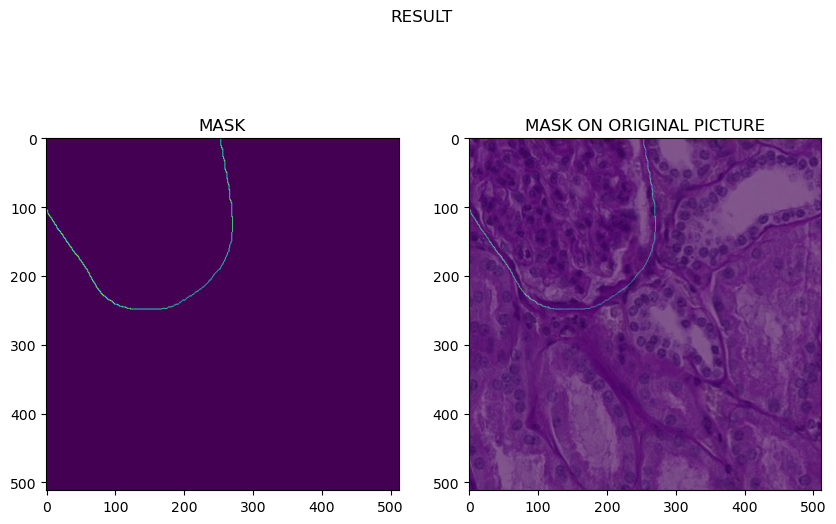

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plt.suptitle('RESULT', x=0.5, y=0.8)

ax[0].set_title('MASK', fontsize=12)
ax[1].set_title('MASK ON ORIGINAL PICTURE', fontsize=12)

ax[0].imshow(a)

I = plt.imread(f"{data_directory}/train/0006ff2aa7cd.tif")
ax[1].imshow(I)
ax[1].imshow(a, alpha=0.6)

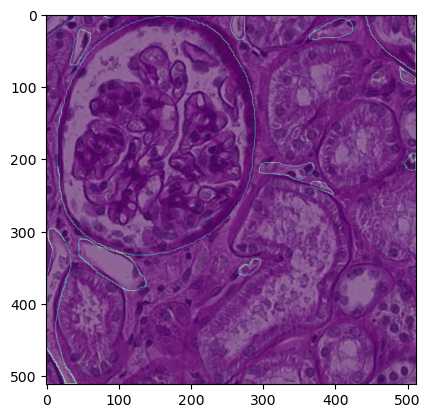

In [10]:
l = []
for i in range(len(result["00da8fdf2391"])):
    arr = result["00da8fdf2391"][i]["coordinates"]
    bitmap = to_bitmap(arr)
    # print(bitmap.shape)
    l.append(bitmap)

l = np.array(l)
# print(l.shape)
arr = np.sum(l, axis=0)
# print(arr.shape)

I = plt.imread(f"{data_directory}/train/00da8fdf2391.tif")
plt.imshow(I)
plt.imshow(arr, alpha=0.5)

plt.show() 

**tile_meta.csv** - Metadata for each image. The hidden version of this file also contains metadata for the test set tiles.
* source_wsi Identifies the WSI this tile was extracted from.
* {i|j} The location of the upper-left corner within the WSI where the tile was extracted.
* dataset The dataset this tile belongs to, as described above.

In [11]:
tile_meta = pd.read_csv(f"{data_directory}/tile_meta.csv")
tile_meta

id  source_wsi  dataset      i      j
0     0006ff2aa7cd           2        2  16896  16420
1     000e79e206b7           6        3  10240  29184
2     00168d1b7522           2        2  14848  14884
3     00176a88fdb0           7        3  14848  25088
4     0033bbc76b6b           1        1  10240  43008
...            ...         ...      ...    ...    ...
7028  ffd37b5c6598          13        3  13824  21504
7029  ffd3d193c71e           3        2   7680  16896
7030  ffd77e2517af          13        3  15872  28160
7031  ffe3cbb81f72          10        3  15456  23000
7032  ffe40e3bc324           9        3  13824  19456

[7033 rows x 5 columns]

**wsi_meta.csv** - Metadata for the Whole Slide Images the tiles were extracted from.
* source_wsi Identifies the WSI.
* age, sex, race, height, weight, and bmi demographic information about the tissue donor.

In [12]:
pd.read_csv(f"{data_directory}/wsi_meta.csv")

source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5

# Data analysis

### Visualize the given image and its 8 surrounding images

printed image is b815cc48bb76


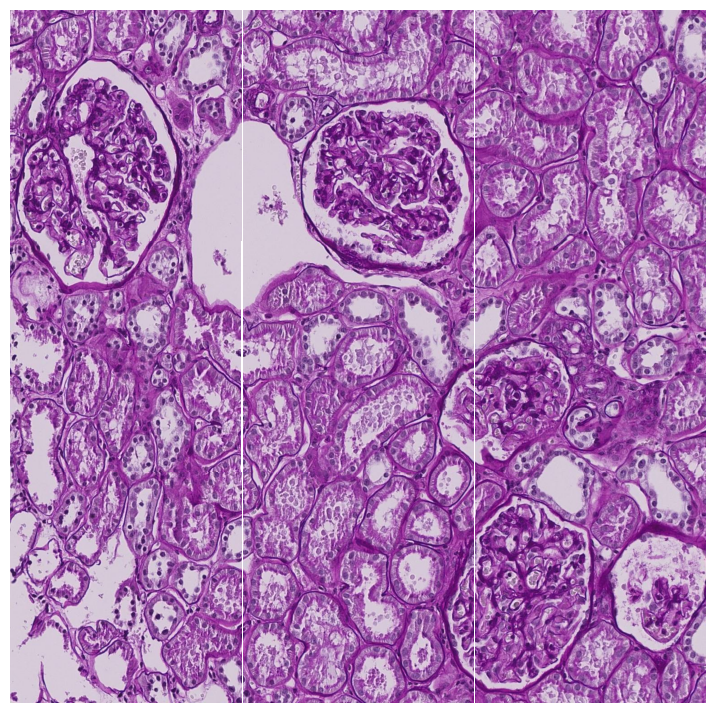

In [13]:
def visualize_surrounding_images(img_id: str) -> None:
    # Get the central image
    img = tile_meta.loc[tile_meta["id"] == img_id]
    img_i, img_j = img["i"].values[0], img["j"].values[0]
    img_wsi = img["source_wsi"].values[0]

    # position of the first image
    x, y = img_i - 512, img_j - 512

    # image plot frame
    grid_size = 3
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(9, 9))

    # iterate over the grid
    for i in range(grid_size):
        for j in range(grid_size):
            axs[j, i].axis('off')
            x_, y_ = x + i * 512, y + j * 512
            try:
                current_img = tile_meta.loc[(tile_meta["i"] == x_) & 
                                            (tile_meta["j"] == y_) & 
                                            (tile_meta["source_wsi"] == img_wsi)]["id"].values[0]
            except IndexError:
                print(f"image with given position {x_}, {y_} and wsi {img_wsi} not found")
                continue
            
            # display the image in the corresponding subplot
            img_file = f"{data_directory}/train/{current_img}.tif"
            try:
                image = plt.imread(img_file)
                axs[j, i].imshow(image)
            except FileNotFoundError:
                continue

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# load images to a list
# https://stackoverflow.com/questions/7336096/python-glob-without-the-whole-path-only-the-filename
img_file = [os.path.basename(x) for x in glob.glob(f'{data_directory}/train/*.tif')]
img_filename = str(random.choice(img_file))[:-4]

print(f"printed image is {img_filename}")
visualize_surrounding_images(img_filename)

# some images do not have all surrounding images

### Grayscale conversion

In [14]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def convert_all_gray(parent_path='./', gray_dir_name='train_gray'):
    gray_path = os.path.join(parent_path, gray_dir_name)
    print(f"Converted pictures will be saved to '{gray_path}'")
    Path(gray_path).mkdir(exist_ok=True)

    tif_files = glob.glob(os.path.join(f'{data_directory}/train', '*.tif'))
    for file_path in tqdm(tif_files):
        gray_file_path = os.path.join(gray_path, os.path.basename(file_path))

        # if exists don't convert again
        if os.path.exists(gray_file_path):
            continue

        img = np.array(Image.open(file_path))
        img_gray = rgb2gray(img)

        Image.fromarray(img_gray).save(gray_file_path)

# convert_all_gray()

#gray_image_filename = glob.glob(f'{data_directory}/train_gray/*.tif')[0]
#print(f'Visualizing {gray_image_filename}')
#
#img = mpimg.imread(gray_image_filename)
#img_show = plt.imshow(img, cmap=plt.get_cmap('gray'))

### Testing if there is any image that has no annotation
The competition data comprises tiles extracted from five Whole Slide Images (WSI) split into two datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.

- All of the test set tiles are from Dataset 1.
- Two of the WSIs make up the training set, two WSIs make up the public test set, and one WSI makes up the private test set.
- The training data includes Dataset 2 tiles from the public test WSI, but not from the private test WSI.
We also include, as Dataset 3, tiles extracted from an additional nine WSIs. These tiles have not been annotated. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.

In [15]:
tif_files = glob.glob(os.path.join(f'{data_directory}/train', '*.tif'))
dic = {}
for file_path in tif_files:
    file_name = Path(file_path).name.split('.')[0]
    dataset_number = tile_meta.loc[tile_meta["id"] == file_name]['dataset'].item()
    dic[dataset_number] = dic.get(dataset_number, 0) + 1

sorted_dic = dict(sorted(dic.items(), key=lambda item: item[0]))
print(f'Number of tiles for each dataset for all train tiles\n{sorted_dic}')

Number of tiles for each dataset for all train tiles
{1: 422, 2: 1211, 3: 5400}


#### For all files:
Number of tiles for each dataset for all train tiles
{1: 422, 2: 1211, 3: 5400}

In [16]:
tif_files = glob.glob(os.path.join(f'{data_directory}/train', '*.tif'))
without_annotation = []
for file_path in tif_files:
    file_name = Path(file_path).name.split('.')[0]
    try:
        result[file_name]
    except:
        without_annotation.append(file_name)

print(f"{len(without_annotation)} images does not have annotations")

dic = {}
for tif_id in without_annotation:
    source_wsi = tile_meta.loc[tile_meta["id"] == tif_id]['source_wsi'].item()
    dic[source_wsi] = dic.get(source_wsi, 0) + 1

sorted_dic = dict(sorted(dic.items(), key=lambda item: item[0]))
pd.DataFrame(pd.Series(sorted_dic), columns=['Number of images without annotations'])

5400 images does not have annotations


Number of images without annotations
6                                    600
7                                    600
8                                    600
9                                    600
10                                   600
11                                   600
12                                   600
13                                   600
14                                   600

#### Results from all files:
5400 images does not have annotations
{6: 600, 7: 600, 8: 600, 9: 600, 10: 600, 11: 600, 12: 600, 13: 600, 14: 600}

In [17]:
# !pip install opencv-python
# !apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
%pip install opencv-python

import cv2

def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

#image  deskew function
def  deskew_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image  gray  function
def  gray_image(image):
    mask = create_mask_for_image(image)
    output = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
    return output/255

#image  thresh  function
def  thresh_image(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    output = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV) #+cv.THRESH_OTSU)
    return output


#image  rnoise  function
def  rnoise_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image  dilate  function
def  dilate_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image  erode  function
def  erode_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image  opening  function
def  opening_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#image canny function
def  canny_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#image segmentation function
def segment_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255


#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

l = []
for i in range(len(result["00da8fdf2391"])):
    arr = result["00da8fdf2391"][i]["coordinates"]
    bitmap = to_bitmap(arr)
    # print(bitmap.shape)
    l.append(bitmap)

l = np.array(l)
#print(l.shape)
arr = np.sum(l, axis=0)
#print(arr.shape)

img = cv2.imread('data/train/00da8fdf2391.tif')

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: opencv-python in d:\user\yannick\envs\hacking_the_human\lib\site-packages (4.8.0.74)



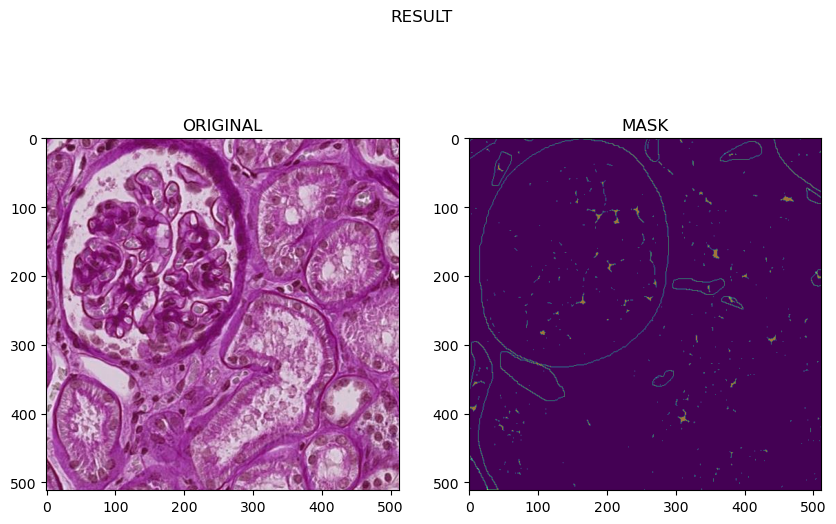

In [18]:

#mask
image_mask = create_mask_for_image(img)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plt.suptitle('RESULT', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)

ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[1].imshow(arr, alpha=0.5);

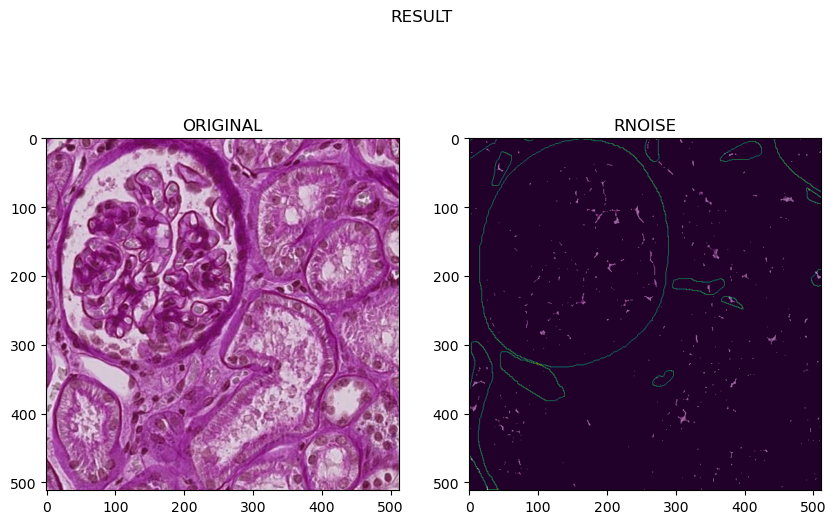

In [19]:
#rnoise
image_rnoise = rnoise_image(img)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plt.suptitle('RESULT', x=0.5, y=0.8)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('RNOISE', fontsize=12)

ax[0].imshow(img/255)
ax[1].imshow(image_rnoise)
ax[1].imshow(arr, alpha=0.5);

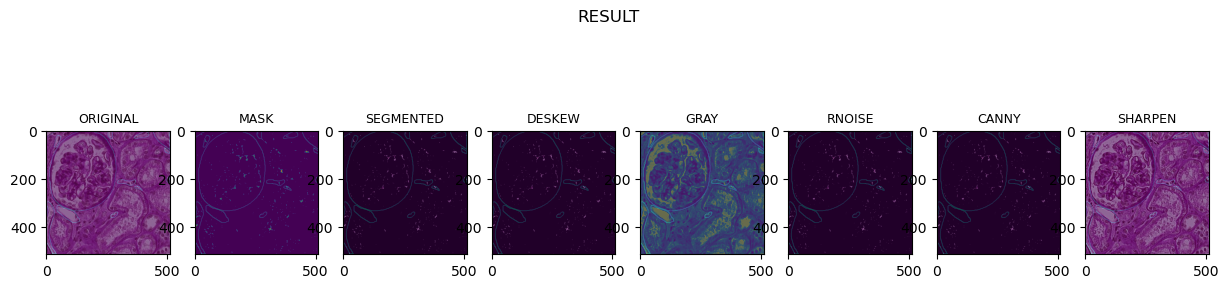

In [20]:
image_mask = create_mask_for_image(img)

#segmentation
image_segmented = segment_image(img)

#deskew
image_deskew = deskew_image(img)

#gray
image_gray = gray_image(img)

#rnoise
image_rnoise = rnoise_image(img)

#canny
image_canny = canny_image(img)

#sharpen the image
image_sharpen = sharpen_image(img)

fig, ax = plt.subplots(1, 8, figsize=(15, 6))
plt.suptitle('RESULT', x=0.5, y=0.8)

ax[0].set_title('ORIGINAL', fontsize=9)
ax[1].set_title('MASK', fontsize=9)
ax[2].set_title('SEGMENTED', fontsize=9)
ax[3].set_title('DESKEW', fontsize=9)
ax[4].set_title('GRAY', fontsize=9)
ax[5].set_title('RNOISE', fontsize=9)
ax[6].set_title('CANNY', fontsize=9)
ax[7].set_title('SHARPEN', fontsize=9)

ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_deskew)
ax[4].imshow(image_gray )
ax[5].imshow(image_rnoise)
ax[6].imshow(image_canny)
ax[7].imshow(image_sharpen)

ax[0].imshow(arr, alpha=0.5)
ax[1].imshow(arr, alpha=0.5)
ax[2].imshow(arr, alpha=0.5)
ax[3].imshow(arr, alpha=0.5)
ax[4].imshow(arr, alpha=0.5)
ax[5].imshow(arr, alpha=0.5)
ax[6].imshow(arr, alpha=0.5)
ax[7].imshow(arr, alpha=0.5);


**It looks like only grayscale can be used.**

# Nápady
*   4 třídy pro kazdy pixel (nic, unsure, g...., blood_vessel)
*   0-100,100-200,200-300 třídy. skoro regresní uloha
*   (100, 512,512)

* oddělení mask přes BBOX ?
### Models
*   UNET
*   RCNN

### Todo
### Vizualizace
*   id obrazku -> zobrazeni obrazku + okolnich
*   

## Dataset & Dataloader

Annotated: 1633, Not Anotated: 5400
Total images: 1633


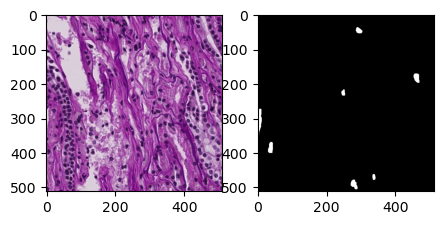

In [21]:
class StructureValue(IntEnum):

    BLOOD_VESSEL = 1
    GLOMERULUS = 2
    #BOTH = 3
    UNSURE = 4

    
    @staticmethod
    def get_value(type):
        if type == 'blood_vessel':
            return StructureValue.BLOOD_VESSEL
        elif type == 'glomerulus':
            return StructureValue.GLOMERULUS
        else:
            return StructureValue.UNSURE


class TifImageDataset(Dataset):
    def __init__(self, img_dir, annotation_file, add_rotated=False, only_annotated = True, count=-1, preprocessing_function=lambda image: image/255):
        self.add_rotated = add_rotated
        self.preprocessing_function = preprocessing_function

        self.img_dir = img_dir
        self.tif_files = [f for f in os.listdir(img_dir)] # Loading file names 
        self.tif_files = np.array(self.tif_files)

        # custom dataset size
        if count == -1:
            count = len(self.tif_files)
        else:
            if add_rotated:
                count //= 4
            count = min(count, len(self.tif_files))  # ceiling value
        
        # load polygons.jsonl file
        with open(f"{data_directory}/polygons.jsonl",'r') as json_file:
            json_list = list(json_file)
        
        # convert lines to dictionary
        result = {}
        for json_str in json_list:
            obj = json.loads(json_str)
            result[obj["id"]] = obj["annotations"]

        # use only annotated files
        before = len(self.tif_files)
        if only_annotated:
            self.tif_files = [f for f in self.tif_files if f.split(".")[0] in list(result.keys())]
        after = len(self.tif_files)
        print(f"Annotated: {after}, Not Anotated: {before - after}")
        
        self.annotations = result
        self.tif_files = self.tif_files[:count]

        # Rotating images
        if add_rotated:
            rotated = self.tif_files
            for rotation in ('90', '180', '270'):
                rotated = np.append(rotated, ([file + '.' + rotation for file in self.tif_files]))
            self.tif_files = rotated

        print(f"Total images: {len(self.tif_files)}")

        
    def __len__(self):
        return len(self.tif_files)

    """
    Converts array of coordinates to 512x512 bitmap (contains 1 if coordinate is present 0 otherwise)
        coordinates (2d array): x, y coordinates
    Returns:
        type: Description of the return value.
    """
    def to_bitmap(self, coordinates):
        res = np.zeros([512, 512], dtype=np.float32)
        for region_coordinates in coordinates:
            region_coordinates = [[y,x] for [x,y] in region_coordinates] # flip (format issue)
            region_mask = ski.draw.polygon2mask((512, 512), region_coordinates)
            res += region_mask
            # for (y, x) in region_coordinates:
            #    res[y, x] = 1
        return res

    def __getitem__(self, idx):
        return self.getitem_and_id(idx)[:2] # first two items
    
    def getitem_and_id(self, idx):
        image_name = self.tif_files[idx]

        # get part after '.tif'
        str_to_found = '.tif'
        index = image_name.index(str_to_found) + len(str_to_found)
        part_after = image_name[index: ]

        image_name = image_name[:index]
        #print(image_name)
        rotate_times = (int(part_after[1:]) / 90) % 4 if part_after else 0
        #if rotate_times:
        #    print('rotatiiiiiiiiiiiiiiiing', rotate_times)

        image = np.rot90(plt.imread(os.path.join(self.img_dir, image_name)).astype(np.float32), rotate_times)
        
        # looking for mask
        mask = np.zeros([512, 512], dtype=np.float32)
        image_uid = image_name.split('.')[0]
        if image_uid in self.annotations:
            for annotation in self.annotations[image_uid]:
                type_value = StructureValue.get_value(annotation['type'])
                if type_value == StructureValue.BLOOD_VESSEL:
                    mask += self.to_bitmap(annotation['coordinates'])


        mask = np.clip(mask, 0, 1)
        mask = np.rot90(mask, rotate_times)

        # Preprocess    
        image = self.preprocessing_function(image) # try this
            
        # Unify format
        image = image.reshape(3, 512,512)
        mask = mask.reshape(1, 512, 512)


        image = torch.from_numpy(image.copy()).float().to(device)
        mask = torch.from_numpy(mask.copy()).float().to(device)
        #image.requires_grad = True
        #mask.requires_grad = True

        return image, mask, image_name


dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', add_rotated=False)

ind = 3
img  = dataset.__getitem__(ind)[0].reshape(512,512,3)
mask = dataset.__getitem__(ind)[1].reshape(512,512,1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(img.cpu().numpy())
axes[1].imshow(mask.cpu().numpy(), cmap="gray")
plt.show()


## Spliting datasets to training and validation dataset

In [22]:
dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', add_rotated=True)
print(len(dataset))
gen1 = torch.Generator().manual_seed(36)

training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], gen1)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

Annotated: 1633, Not Anotated: 5400
Total images: 6532
6532


1 blood_vessel
1 glomerulus
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 blood_vessel
1 glomerulus
1 blood_vessel


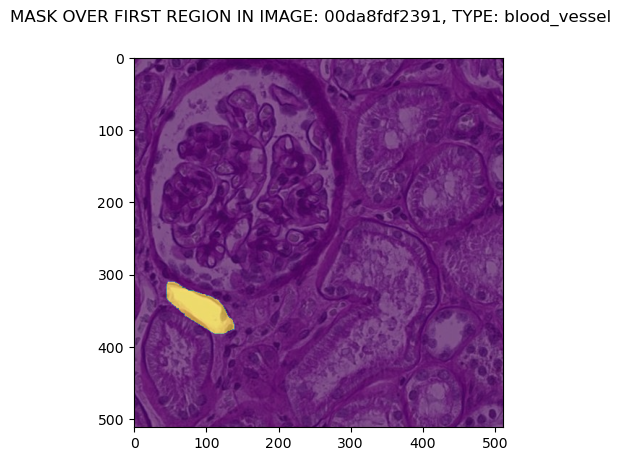

In [23]:
image_shape = (512, 512)
image_to_display = "00da8fdf2391"

for t in result[image_to_display]:
    print(len(t['coordinates']), t['type'])

reg_num = 4
regions = result[image_to_display][reg_num]["coordinates"]
types = result[image_to_display][reg_num]["type"]
region = regions[0]

region = [[y,x] for [x,y] in region] # flip (format issue)
region_mask = ski.draw.polygon2mask(image_shape, region)

plt.suptitle(f'MASK OVER FIRST REGION IN IMAGE: {image_to_display}, TYPE: {types}')
I = plt.imread(f"{data_directory}/train/{image_to_display}.tif")
plt.imshow(I)
plt.imshow(region_mask, alpha=.6);

## IoU (Intersection of Union)

In [24]:
# def calculate_iou(mask1, mask2):
#     # Convert masks to numpy arrays if they are not already
#     mask1 = np.asarray(mask1)
#     mask2 = np.asarray(mask2)

#     print(f"mask1: {mask1.shape}, mask2: {mask2.shape}")

#     # Ensure masks have the same shape
#     if mask1.shape != mask2.shape:
#         raise ValueError("Masks must have the same shape.")

#     # Calculate intersection and union
#     intersection = np.logical_and(mask1, mask2).sum()
#     union = np.logical_or(mask1, mask2).sum()

#     # Handle the case where both masks are empty
#     iou = 1.0 if union == 0 else intersection / union

#     return iou

## Neural network

In [25]:
class UNet(nn.Module):
    def __init__(self, device="cpu"):
        super(UNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, dtype=torch.float32)
        self.sigmoid = nn.Sigmoid()
        self.device=device

    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            y_pred = self.forward(x)
        return (y_pred > 0.5) * 1.0

with torch.no_grad():
    model = UNet()
    model.to(device)
    input = torch.randn(1, 3, 512, 512).to(device)
    output = model(input)
    print(input.shape, output.shape)

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


In [26]:
def train_one_epoch(model, loss_function, optimizer, training_loader, batch_stop = 999999, verbose_interval = -1, verbose = True, show_graph = False):
    if verbose_interval == -1: # set verbose interval to be a nice number
        verbose_interval = len(training_loader) // 7
        verbose_interval = max(verbose_interval, 1)

    start = time.time()
    if verbose:
        iter_count = min(batch_stop, len(training_loader) )
        print(f"Running {iter_count} batches | verbose_interval: {verbose_interval}")
    running_cum_loss = 0
    losses = []
    example_count = 0
    for i, data in enumerate(training_loader):
        if i >= batch_stop:
            break

        inputs, labels = data
        example_count += len(labels) # batch size

        optimizer.zero_grad()
        outputs = model(inputs)
        
        #print(inputs.shape, labels.shape, outputs.shape, )
        #print(str(outputs)[:200])
        #print(str(labels)[:200])
        # print(outputs.shape, labels.shape)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        optimizer.step() # Adjust learning weights
        #print(loss)
        #return 0

        #  report
        losses.append(loss.item())
        running_cum_loss += loss.item() * inputs.shape[0]
        if verbose == True:
            if i % verbose_interval == 0 or i == iter_count - 1:
                elapsed = time.time() - start
                non_training_time = 2
                estimated_time = (iter_count / (i+1))  * elapsed
                print(f"  batch {i+1} loss: {loss.item():.5f} | estimated_time: {(estimated_time + non_training_time)/60:.1f} min | elapsed: {elapsed/60:.1f} min")
            

    
    if show_graph:
        plt.plot(range(1,len(losses)+1),losses, '-')
        plt.title(f"Trained on {example_count} Images: ")
        plt.ylabel("Loss")
        plt.xlabel("Batch Number")
        plt.show()
    # returns avg loss
    return running_cum_loss / example_count


torch.manual_seed(1)

# simple_model = UNet()
# loss_function = nn.BCEWithLogitsLoss() 
# optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

# training_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=300, add_rotated=False)

# training_loader = DataLoader(training_dataset, batch_size=50, shuffle=True) 

# average_loss = train_one_epoch(simple_model, loss_function, optimizer, training_loader, batch_stop=200, verbose=True, show_graph=True)

In [27]:
def get_validation_accuracy(mdl, loss_function, validation_loader):
    running_cum_vloss = 0.0
    vcorrect = 0
    for vdata in validation_loader:
        vinputs, vlabels = vdata
        with torch.no_grad(): # we don't need to alter the model
            voutputs = mdl(vinputs)
            vloss = loss_function(voutputs, vlabels)
        running_cum_vloss += vloss * vinputs.shape[0]
        # count the correctly classified samples
        vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
    
    avg_vloss = running_cum_vloss / len(validation_dataset)
    print(vcorrect, len(validation_dataset))
    vacc = vcorrect / len(validation_dataset)
    return avg_vloss, vacc

def calculate_mAP(outputs, labels):
    num_classes = outputs.size(1)
    y_true = labels.cpu().numpy()
    y_scores = torch.softmax(outputs, dim=1).cpu().numpy()

    mAP = 0.0

    for class_idx in range(num_classes):
        y_true_class = (y_true == class_idx).astype(int)
        y_scores_class = y_scores[:, class_idx]

        # Compute the Average Precision for the current class
        ap = average_precision_score(y_true_class.flatten(), y_scores_class.flatten())
        mAP += ap

    mAP /= num_classes

    return mAP

def get_validation_accuracy(model, loss_function, validation_loader):
    model.eval()  # Set the model to evaluation mode

    total_vloss = 0.0
    total_mAP = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:

            # Forward pass
            outputs = model(inputs)
            vloss = loss_function(outputs, labels)
            total_vloss += vloss.item()

            # Assuming you have a function called `calculate_mAP` to compute mAP
            mAP = calculate_mAP(outputs, labels)
            total_mAP += mAP

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate averages
    avg_vloss = total_vloss / len(validation_loader)
    avg_mAP = total_mAP / len(validation_loader)
    vacc = correct_predictions / total_samples

    return avg_vloss, avg_mAP, vacc


def do_epochs(mdl, loss_function, _optimizer, _training_loader, _validation_loader, epochs = 2, verbose = True):

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch + 1))

        # One training step
        avg_loss = train_one_epoch(mdl, loss_function, _optimizer, _training_loader, verbose = verbose)

        # Validation performance
        avg_vloss, avg_mAP, vacc = get_validation_accuracy(mdl, loss_function, _validation_loader)
        
        # Display
        print(f"  TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuracy: {vacc:.3f}, avg_mAP: {avg_mAP:.3f}")


# simple_model = UNet()

# loss_function = nn.BCEWithLogitsLoss() 
# optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

# dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=100, add_rotated=True)
# gen1 = torch.Generator().manual_seed(36)
# training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.78, 0.22], gen1)
# train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

# average_loss = do_epochs(simple_model, loss_function, optimizer, training_loader, validation_loader, epochs=4, verbose=False)


## Pixel accuracy

although simple to implement it is a bad practice to use in image segmentation

In [28]:
def pixel_accuracy(model, dataloader, break_after = -1):

    if break_after == -1:
        break_after == dataloader.__len__()
    with torch.no_grad():
        model.eval()  # Set the model in evaluation mode

        total_correct = 0
        total_samples = 0

        for i, (inputs, labels) in enumerate(dataloader):
            if i > break_after:
                break 
            # Move data to the same device as the model (CPU or GPU)
            inputs = inputs.reshape(1, 3, 512, 512).to(model.device)
            labels = labels.reshape(1, 1, 512, 512).to(model.device)

            # Make predictions on the batch
            predictions = model.predict(inputs)

            # Convert predictions and labels to numpy arrays for easier comparison
            predictions = predictions.cpu().numpy().flatten()
            labels = labels.cpu().numpy().flatten()

            # Count the correct predictions in the batch
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)

        # Calculate the accuracy
        accuracy = total_correct / total_samples

        model.train()  # Set the model back to training mode

    return accuracy

# pixel_accuracy(simple_model, training_dataset, break_after=50)

# Help function
Getting pred x label | train x label data in separate lists

In [29]:
def get_preds_and_labels(model, dataset: Dataset, count: int) -> List[Tuple[np.array, np.array]]:
    preds = []
    labels = []
    for i, (train_mask, label) in enumerate(dataset):
        if not i < count:
            break
        train_mask = train_mask.reshape(1, 3, 512, 512)
        preds.append(model.predict(train_mask).cpu().numpy())
        labels.append(label.cpu().numpy())
    return preds, labels

def get_train_and_labels(model, dataset: Dataset, count: int) -> List[Tuple[np.array, np.array]]:
    train = []
    labels = []
    for i, (train_mask, label) in enumerate(dataset):
        if not i < count:
            break
        train_mask = train_mask.reshape(1, 3, 512, 512)
        train.append((train_mask).cpu().numpy())
        labels.append(label.cpu().numpy())
    return train, labels

def get_train_and_labels_and_preds(model, dataset: Dataset, count: int, index: int = 0) -> List[Tuple[np.array, np.array]]:
    if index + count > len(dataset):
        raise Exception("index + count bigger than len(dataset)")
    train = []
    labels = []
    preds = []
    ids = []
    for i in range(index, index + count):
        train_mask, label, id = dataset.getitem_and_id(i)
        train_mask = train_mask.reshape(1, 3, 512, 512)
        train.append((train_mask).cpu().numpy())
        preds.append(model.predict(train_mask).cpu().numpy())
        labels.append(label.cpu().numpy())
        ids.append(id)
    return train, labels, preds, ids

# something_missing = get_train_and_labels_and_preds( # something missing
#     simple_model, 
#     TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', add_rotated=False),
#     count=3)

## mAP (Mean Average Precision)

In [30]:
from sklearn.metrics import precision_recall_curve, auc

import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        iou = 1.0
    else:
        iou = intersection / union
    return iou

def calculate_ap(precision, recall):
    return auc(recall, precision)

# probably wrong, its literally mean
def calculate_mAP_FAKE(model, dataset, threshold=0.5, max_iter = 10):
    preds, labels = get_preds_and_labels(model, dataset, max_iter)
    n = len(preds)
    if n == 0:
        return 0.0

    sum = 0
    for pred, label in zip(preds, labels):
        sum += calculate_iou(pred, label)
    return sum / n



# mAP = calculate_mAP_FAKE(simple_model, training_dataset, max_iter=10)
# print("mAP:", mAP)


In [31]:
def overlay_image_with_bitmap(image, bitmap, color, mask_opacity_threshold = 0.3):
    image = image.reshape(512,512,3)
    bitmap = bitmap.reshape(512, 512)
    # Create a mask from the binary bitmap (convert it to a 3-channel mask)
    mask = np.stack([bitmap, bitmap, bitmap], axis=-1)

    # Set the color for the areas where the mask is one
    mask *= np.array(color).reshape(1, 1, 3) 

    bitmap_max = max(mask_opacity_threshold, bitmap.max()) # if mask is opaque

    # Blend the original image and the colored mask
    overlaid_image = image.copy()
    overlaid_image[bitmap == bitmap_max] = mask[bitmap == bitmap_max]

    return overlaid_image

def get_bounding_image(id, image_opacity=0.6):
    img = plt.imread(f"{data_directory}/train/{id}")
    blood_vessels = np.zeros([512, 512])
    glomeruluses = np.zeros([512, 512])
    unsures = np.zeros([512, 512])
    for annotations in result[id.split(".")[0]]:
        if annotations["type"] == "blood_vessel":
            blood_vessels += to_bitmap(annotations["coordinates"])
        elif annotations["type"] == "glomerulus":
            glomeruluses += to_bitmap(annotations["coordinates"])
        elif annotations["type"] == "unsure":
            unsures += to_bitmap(annotations["coordinates"])
    
    img = np.array(img * image_opacity) / 255 

    img = overlay_image_with_bitmap(img, blood_vessels, (0, 1, 1))
    img = overlay_image_with_bitmap(img, glomeruluses, (1, 1, 0))
    img = overlay_image_with_bitmap(img, unsures, (1, 0, 1))

    return img, blood_vessels

def get_predicted_image(model, id, pred_color, image_opacity=0.6, pred_opacity=1):
    img = plt.imread(f"{data_directory}/train/{id}")
    img = img.reshape(1,3,512,512).copy()
    img = np.array(img) / 255 
    output = model.predict(torch.from_numpy(img.copy()).float())

    output = output.squeeze()

    # torch tensor to numpy array
    opaque_mask=output.numpy() 
    mask = opaque_mask * pred_opacity


    img = img.reshape(512,512, 3) * image_opacity
    img = overlay_image_with_bitmap(img, mask, pred_color)

    return img, opaque_mask

def grayscale_to_rgb(mask, color):
    mask = mask.reshape(512, 512, 1)
    color=np.array(color)
    color = color.reshape(1, 1, 3)
    res = np.stack([mask*0, mask, mask], axis=-1)
    res = res.reshape(512, 512, 3)
    return res

def label_vs_pred_bounding(model, count = 3, index = 0, pred_color = (0, 1, 1), image_opacity=.7, pred_opacity=1, zoom = 1):
    ids = result_ids[index: index + count]
    pred_color = np.array(pred_color).reshape(1, 1, 3)
    if isinstance(ids, str) :
        ids = [ids]

    fig, axes = plt.subplots(nrows=len(ids), ncols=3, figsize=(8 * zoom, 15*zoom))
    for i in range(len(ids)):
        bounding, b_mask = get_bounding_image(ids[i] + ".tif", image_opacity)
        predicted, p_mask = get_predicted_image(model, ids[i] + ".tif", pred_color, image_opacity, pred_opacity=pred_opacity)
        #print(bounding.max(), b_mask.max(), predicted.max(), p_mask.max())

        
        axes[i][0].set_title(f"{ids[i]}: {np.sum(b_mask):.0f} bits")
        axes[i][1].set_title(f"Predicted: {np.sum(p_mask):.0f} bits")
        axes[i][2].set_title(f"Img + Predicted")

        axes[i][0].imshow(bounding, vmin=0, vmax=1)
        axes[i][1].imshow(grayscale_to_rgb(p_mask, pred_color), vmin=0, vmax=1)
        axes[i][2].imshow(predicted, vmin=0, vmax=1)

        axes[i][0].axis('off')
        axes[i][1].axis('off')
        axes[i][2].axis('off')

    plt.show()

# label_vs_pred_bounding(simple_model, count = 5, index = 10)

In [32]:
def get_predicted_mask(model, train_image):
    tensor = torch.from_numpy(train_image.reshape(1,3,512,512).copy()).float().to(device)
    output = model.predict(tensor)
    #print(f"output: {output.shape}")
    output = output.squeeze().cpu().numpy()
    #print(f"output after squeeze: {output.shape}")
    return output

def label_vs_pred(model, dataset, count = 3, index = 0, pred_color = (0, 1, 1), background_opacity=.7, zoom=1):
    train_images, labels, preds, ids = get_train_and_labels_and_preds(model, dataset, count = count, index = index)
    fig, axes = plt.subplots(nrows=len(labels), ncols=3, figsize=(8*zoom, 15*zoom))
        
    for i, (train_image, label, pred, id) in enumerate(zip(train_images, labels, preds, ids)):
        pred = get_predicted_mask(model, train_image.reshape(1,3,512,512))
        train_image = np.array(train_image * background_opacity)

        label_image = overlay_image_with_bitmap(train_image, label, (0, 1, 1))
        
        #prediction_image = overlay_image_with_bitmap(train_image, pred, (0, 1, 1))
        
        bounding_image, _ = get_bounding_image(id, background_opacity)

        bounding_image = np.clip(bounding_image, 0, 1)

        iou = calculate_iou(label, pred)

        #print(np.unique(pred))
        #print(train_image.max(), label.max(), pred.max(), label_image.max(), "---", train_image.min(), label.min(), pred.min(), label_image.min())

        axes[i][0].set_title(f"Poly {id}")
        axes[i][1].set_title(f"Train {np.sum(label):.0f} bits")
        axes[i][2].set_title(f"Pred IoU: {iou:.4f}")

        axes[i][0].imshow(bounding_image.reshape(512, 512, 3), vmin=0, vmax=1)
        axes[i][1].imshow(label_image.reshape(512, 512, 3), vmin=0, vmax=1)
        print("hey")
        print(pred.max(), pred.min())
        axes[i][2].imshow(pred.reshape(512, 512, 1), cmap="gray", vmin=0, vmax=1)

        axes[i][0].axis('off')
        axes[i][1].axis('off')
        axes[i][2].axis('off')

    fig.suptitle(f"Labels vs Predictions ({count}x)", fontsize=20)
    plt.show()

# index = 5
# label_vs_pred(
#     simple_model, 
#     TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', add_rotated=False),
#     count=5, index = 0
#     )

In [33]:
import torch
import torch.nn as nn


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class UNetComplex(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, device="cpu"):
        super(UNetComplex, self).__init__()
        # Downsampling
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)
        # Upsampling
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256 + 256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128 + 128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64 + 64, out_channels, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

        self.device = device

    def forward(self, x):
        # Downsample path
        x1 = self.down1(x)
        x2 = self.down2(nn.MaxPool2d(2)(x1))
        x3 = self.down3(nn.MaxPool2d(2)(x2))
        x4 = self.down4(nn.MaxPool2d(2)(x3))

        # Upsample path with skip connections
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up4(x)

        # Apply sigmoid activation
        x = self.sigmoid(x)

        return x

    def predict(self, x):
        with torch.no_grad():
            y_pred = self.forward(x)
        return (y_pred > 0.5) * 1.0


# # Test the model with example input
# model = UNetComplex(in_channels=3, out_channels=1)
# input_example = torch.randn(1, 3, 512, 512)
# output_example = model(input_example)
# print("Output shape:", output_example.shape)


In [34]:
# torch.manual_seed(1)
# gpt_model = UNetComplex().to(device)
# loss_function = nn.BCEWithLogitsLoss() 
# optimizer = optim.Adam(gpt_model.parameters(), lr=0.001) 

# training_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=20, add_rotated=True)

# training_loader = DataLoader(training_dataset, batch_size=1, shuffle=True) 


# average_loss = train_one_epoch(gpt_model, loss_function, optimizer, training_loader, verbose=True, batch_stop=99999999, verbose_interval=1, show_graph=True) 

In [35]:
# calculate_mAP_FAKE(model, training_dataset, max_iter=10)

In [36]:
# label_vs_pred_bounding(gpt_model, zoom=1, index=5, count = 5)


In [37]:
# training_dataset.getitem_and_id(1)
# label_vs_pred(gpt_model, training_dataset, count = 5, index=0)

In [38]:
# pixel_accuracy(gpt_model, training_dataset, break_after=10)

## Module: `segmentation_models_pytorch` 

In [39]:
# !pip install segmentation-models-pytorch
# !pip install torch torchvision

In [40]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

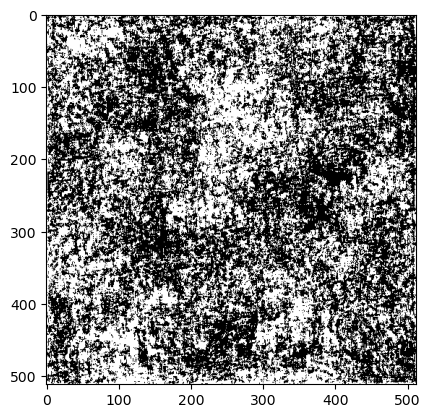

In [41]:
class UNetInstanceSegmentation(nn.Module):
    def __init__(self, num_classes=1, num_channels=3):
        super(UNetInstanceSegmentation, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet18",  # You can choose different encoder backbones if desired.
            encoder_weights="imagenet",
            in_channels=num_channels,
            classes=num_classes,
            activation='sigmoid'
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        with torch.no_grad():
            y_pred = self.forward(x)
        return (y_pred > 0.5) * 1.0

model = UNetInstanceSegmentation()
model.to(device)

inp = torch.randn(1, 3, 512, 512).to(device)
output_mask = model.predict(inp)

plt.imshow(output_mask.cpu().numpy().reshape(512, 512, 1), cmap="gray");

In [42]:
preprocessing_fn = get_preprocessing_fn('resnet18', pretrained='imagenet')
preprocessing_fn(torch.randn(512, 512, 3).numpy())

array([[[-2.12768135, -2.04375586, -1.83083837],
        [-2.12370212, -2.05710907, -1.81622644],
        [-2.11357057, -2.07489545, -1.76983601],
        ...,
        [-2.10815022, -2.03704137, -1.7987333 ],
        [-2.11545399, -2.0418945 , -1.83777838],
        [-2.10723609, -2.06901524, -1.80894065]],

       [[-2.13395957, -2.02280208, -1.7993987 ],
        [-2.11566957, -2.04892737, -1.78026339],
        [-2.10515375, -2.08566687, -1.81299725],
        ...,
        [-2.14579724, -2.07183983, -1.78498589],
        [-2.13508034, -2.02239562, -1.82527857],
        [-2.10300756, -2.038028  , -1.79175334]],

       [[-2.10097461, -2.05564186, -1.81286268],
        [-2.14521358, -2.04139791, -1.79806554],
        [-2.10454735, -2.03229435, -1.82002167],
        ...,
        [-2.09420892, -2.0411888 , -1.84049202],
        [-2.1238921 , -2.03413858, -1.80744583],
        [-2.11814862, -2.04332247, -1.80185534]],

       ...,

       [[-2.14513931, -2.05554953, -1.79369493],
        [-2

In [43]:
torch.cuda.empty_cache()
iseg_model = UNetInstanceSegmentation()

iseg_model.to(device)
loss_function = losses.DiceLoss(losses.BINARY_MODE)

optimizer = optim.Adam(iseg_model.parameters(), lr=0.00008)

training_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=2, add_rotated=True, preprocessing_function=preprocessing_fn)

training_loader = DataLoader(training_dataset, batch_size=16, shuffle=True) 

#average_loss = train_one_epoch(iseg_model, loss_function, optimizer, training_loader, batch_stop=5000, verbose=True, show_graph=True)

Annotated: 1633, Not Anotated: 5400
Total images: 6532


In [44]:
#torch.save(iseg_model.state_dict(), f"{data_directory}/sleepmodel_unetinstancesegmentation")


In [45]:
# calculate_mAP_FAKE(iseg_model, training_dataset, max_iter=10)

Annotated: 1633, Not Anotated: 5400
Total images: 1633
hey
1.0 0.0
hey
1.0 0.0
hey
1.0 0.0
hey
1.0 0.0
hey
1.0 0.0


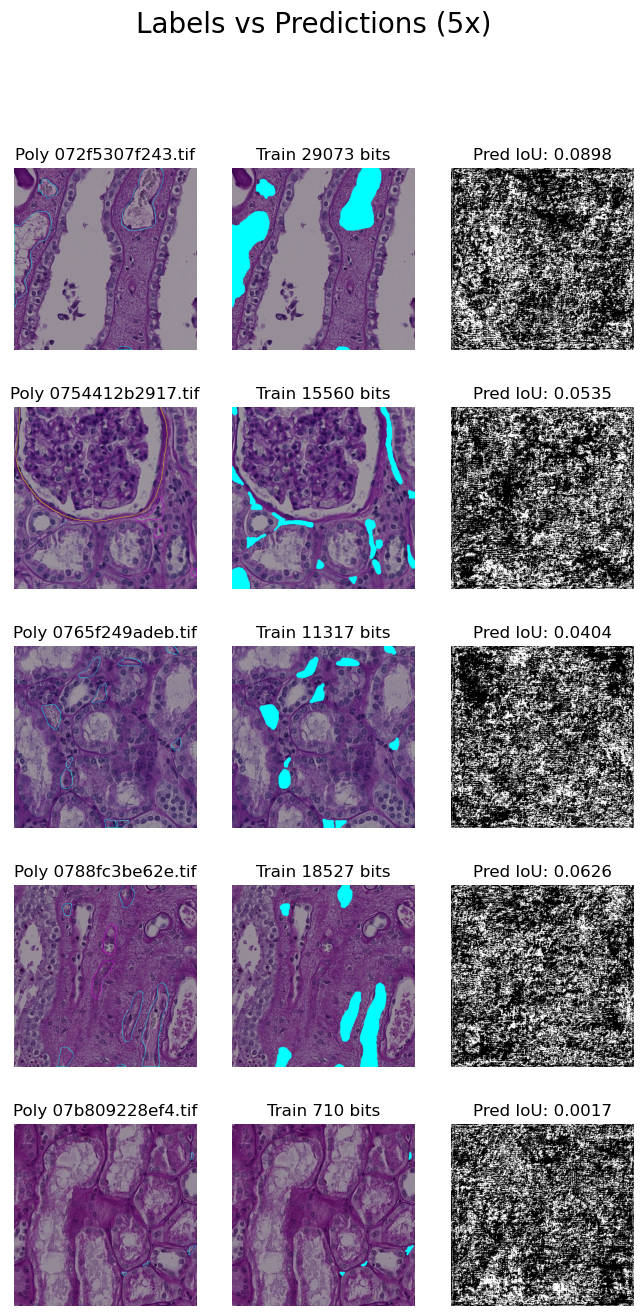

In [46]:
label_vs_pred(
    iseg_model, 
    TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', add_rotated=False),
    count=5, index = 42
    )

In [47]:
iseg_model = UNetInstanceSegmentation()

iseg_model.to(device)

loss_function = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(iseg_model.parameters(), lr=0.001)

dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=100, add_rotated=True)
gen1 = torch.Generator().manual_seed(36)
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.78, 0.22], gen1)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

#average_loss = do_epochs(iseg_model, loss_function, optimizer, training_loader, validation_loader, epochs=2, verbose=True)

Annotated: 1633, Not Anotated: 5400
Total images: 100


hey
1.0 0.0
hey
1.0 0.0
hey
1.0 0.0
hey
1.0 0.0
hey
1.0 0.0


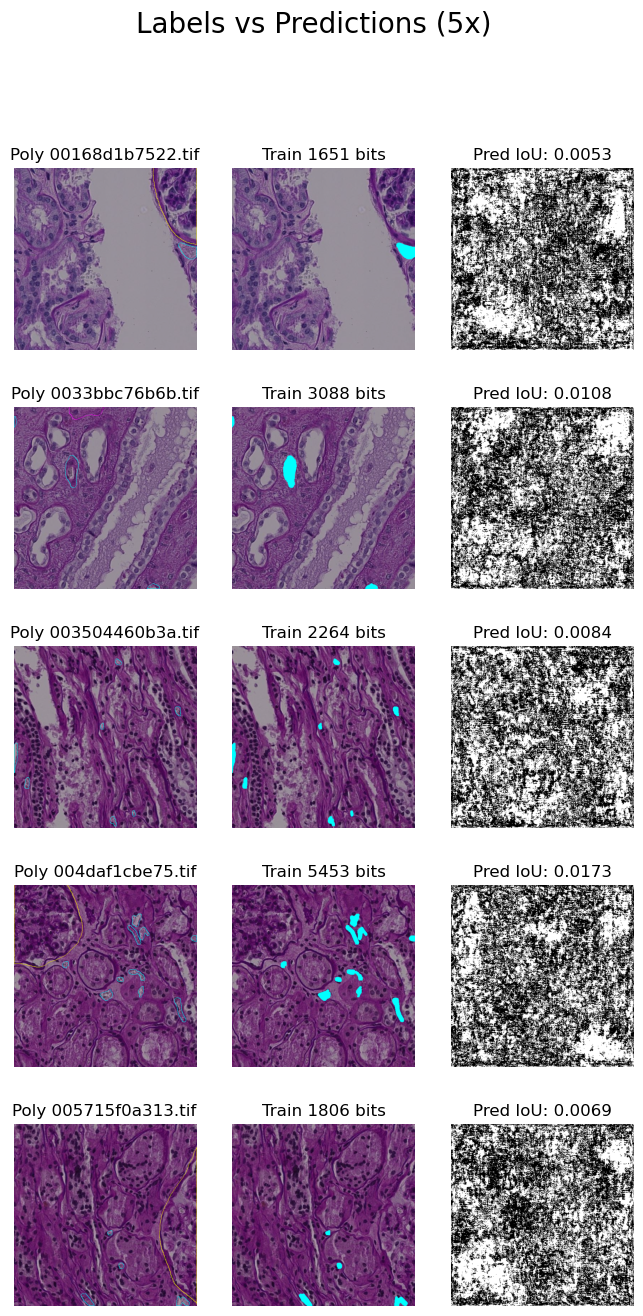

In [48]:

label_vs_pred(
    iseg_model, 
    dataset,
    count=5, index = 1
    )

In [49]:
# from torchmetrics.detection import MeanAveragePrecision

# def validate_model(model, dataloader):
#     # Set the model in evaluation mode

#     model.eval()

#     # Create the MeanAveragePrecision metric
#     mAP_metric = MeanAveragePrecision()  # We have 1 class for binary segmentation

#     # Lists to store ground truth and prediction tensors
#     all_targets = []
#     all_predictions = []

#     # Iterate over the dataloader
#     with torch.no_grad():
#         for batch in dataloader:
#             inputs, targets = batch
#             inputs = inputs.to('cuda')
#             targets = targets.to('cuda')

#             # Forward pass through the model to get predictions
#             predictions = model(inputs)

#             # Adjust the shapes of the predictions and targets
#             # (batch, 1, 512, 512) to (batch, 512, 512)
#             predictions = predictions.squeeze(1)
#             targets = targets.squeeze(1)

#             # Convert predictions and targets to binary values (0 or 1)
#             predictions = (predictions > 0.5).float()
#             targets = (targets > 0.5).float()

#             all_targets.append(targets)
#             all_predictions.append(predictions)

#     # Concatenate the lists of tensors to create a single tensor
#     all_targets = torch.cat(all_targets, dim=0)
#     all_predictions = torch.cat(all_predictions, dim=0)

#     # Calculate the mean average precision
#     mAP_metric.update(all_predictions, all_targets)
#     mean_average_precision = mAP_metric.compute()

#     return mean_average_precision.item()

# mAP = validate_model(model, validation_loader)

# Leo wants to play too :)

### My own U-NET
inspired by: https://www.youtube.com/watch?v=csFGTLT6_WQ

In [50]:
class DConv(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, prob=.1):
        super(DConv, self).__init__()
        self.dconv = nn.Sequential (
            nn.Conv2d(in_chan, out_chan, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True),
            nn.Dropout(p=prob),
            nn.Conv2d(out_chan, out_chan, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.dconv(x)

class DConvT(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=2, prob=.1):
        super(DConvT, self).__init__()
        self.dconvt = nn.Sequential (
            nn.ConvTranspose2d(in_chan, out_chan, kernel_size=kernel_size, stride=stride, padding=1),
            nn.Conv2d(out_chan, out_chan, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True),
            nn.Dropout(p=prob),
            nn.Conv2d(out_chan, out_chan, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.dconvt(x)

class UNet2(nn.Module):
    def __init__(self, in_chan=3, out_chan=1, device="cpu"):
        super(UNet2, self).__init__()        

        # Down Sampling
        self.down1 = DConv(in_chan, 64)
        self.down2 = DConv(64, 128)
        self.down3 = DConv(128, 256)
        self.down4 = DConv(256, 512)

        # Up Sampling
        self.up1 = DConvT(512, 256, kernel_size=2, stride=2)
        self.up2 = DConvT(256 + 256, 128, kernel_size=2, stride=2)
        self.up3 = DConvT(128 + 128, 64, kernel_size=2, stride=2)
        self.up4 = DConvT(64 + 64, out_chan, kernel_size=3, stride=1)
        self.sigmoid = nn.Sigmoid()

        self.device = device

    def forward(self, x):
        # Downsample path
        x1 = self.down1(x)
        x2 = self.down2(nn.MaxPool2d(2)(x1))
        x3 = self.down3(nn.MaxPool2d(2)(x2))
        x4 = self.down4(nn.MaxPool2d(2)(x3))

        # Upsample path with skip connections
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up4(x)

        # Apply sigmoid activation
        x = self.sigmoid(x)

        return x

    def predict(self, x):
        with torch.no_grad():
            y_pred = self.forward(x)
        return (y_pred > 0.5) * 1.0


# Test the model with example input
model = UNet2(in_chan=3, out_chan=1)
# input_example = torch.randn(1, 3, 512, 512)
# output_example = model(input_example)
# print("Output shape:", output_example.shape)

# inp = torch.randn(1, 3, 512, 512).to(device)
# output_mask = model.predict(inp)

# plt.imshow(output_mask.reshape(512, 512, 1), cmap="gray");

In [51]:
torch.cuda.empty_cache()
torch.manual_seed(1)
leo_model = UNet2().to(device)
#loss_function = nn.BCEWithLogitsLoss() 
loss_function = losses.DiceLoss(losses.BINARY_MODE)
optimizer = optim.Adam(leo_model.parameters(), lr=0.0001) 

training_dataset = TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', count=5000000, add_rotated=True)
training_loader = DataLoader(training_dataset, batch_size=4, shuffle=True) 

average_loss = train_one_epoch(leo_model, loss_function, optimizer, training_loader, verbose=True, batch_stop=59, show_graph=True)

Annotated: 1633, Not Anotated: 5400
Total images: 6532
Running 59 batches
  batch 1 loss: 0.93105 | estimated_time: 21.1 min | elapsed: 0.4 min


KeyboardInterrupt: 

In [ ]:
label_vs_pred(
    leo_model, 
    TifImageDataset(f'{data_directory}/train/', f'{data_directory}/polygons.jsonl', add_rotated=False),
    count=5, 
    index = 42
)

# Saving Model

In [ ]:
final_model = iseg_model
torch.save(model.state_dict(), f"{data_directory}/models/mymodel")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=48bbd743-2622-46ec-99ec-b0bf1e40f98b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>